# Clustering with k-means and k-mediod algorithms

K-means and k-medidd are the most basic unsupervised clustering algorithms.

## k-means

* define any k value as number of clusters that we would like to output
* randomly choose k points from dataset as initial cluster centroids
* until mean values no longer change
  * assign each point in set to their nearest centroid
  * calculate mean points for each k cluster
  * assign each point to their closest mean values

Firstly, lets load our perviously saved [pca-reduced dataset](005-pca.ipynb).

In [13]:
rm(list=ls())
load("/tmp/reduced-iris.RData")
print(head(data))

          [,1]       [,2]
[1,] -2.684126 -0.3193972
[2,] -2.714142  0.1770012
[3,] -2.888991  0.1449494
[4,] -2.745343  0.3182990
[5,] -2.728717 -0.3267545
[6,] -2.280860 -0.7413304


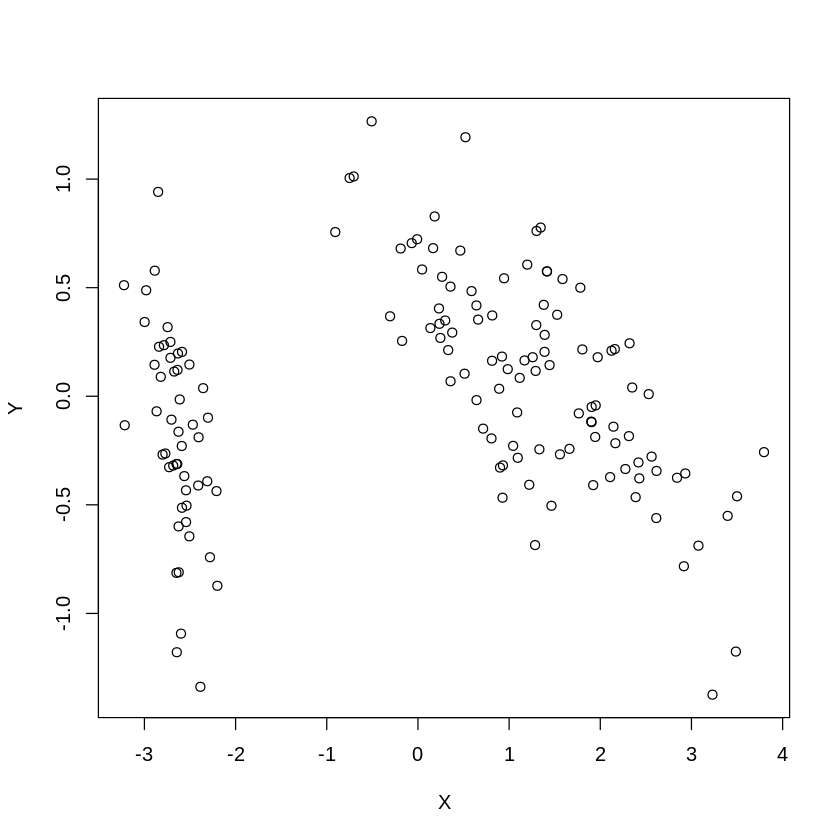

In [14]:
plot(data, xlab = "X", ylab = "Y")

We would like to identify those two clusters with no human intervention. Since we rarely know the "correct" k before clustering, I will choose higher k on purpose.

In [15]:
k <- 3

centroids <- sample(nrow(data), size = k, replace = TRUE)
centroids

[1] 61 74 42

Generate distance matrix, filter out only distances from initial points and select smallest value. 

In [16]:
d <- dist(data, method = "euclidean", diag = TRUE)
d <- as.matrix(d)
distToCentroids <- d[centroids,]
labels <- apply(distToCentroids, 2, which.min)
distToCentroids

,1,2,3,4,5,6,7,8,9,10,⋯,141,142,143,144,145,146,147,148,149,150
61,2.692510,2.4604103,2.6318365,2.4299172,2.732959,2.678219,2.5947528,2.555440,2.4759517,2.4524303,⋯,3.172549,2.951548,2.0434728,3.437087,3.321480,2.850392,2.2213780,2.6403408,2.777375,2.1376192
74,3.640649,3.6358751,3.8109068,3.6695766,3.685829,3.333238,3.7434290,3.564717,3.8286020,3.5951462,⋯,1.439823,1.162528,0.6303595,1.704690,1.574405,1.087365,0.6353279,0.8822901,1.023952,0.4789983
42,1.271144,0.7758352,0.7969966,0.6312914,1.273444,1.775755,0.8519871,1.126680,0.3645329,0.8458306,⋯,5.284574,4.958978,4.2802851,5.547919,5.413405,4.924524,4.4129371,4.7250812,4.866615,4.2903621


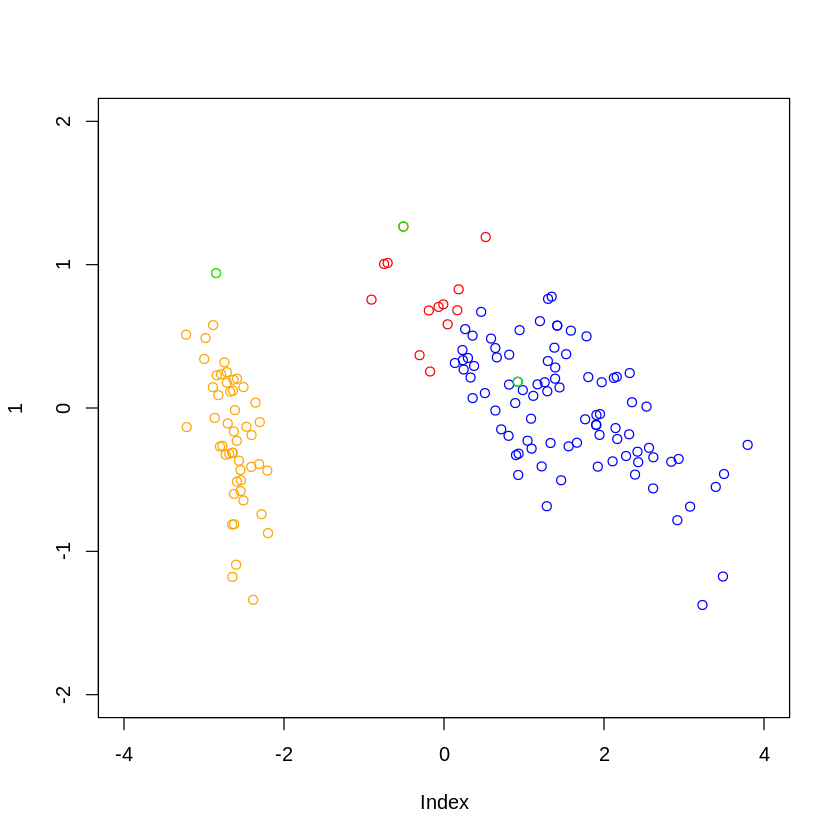

In [17]:
data <- cbind(data, labels)

first <- data[data[, "labels"] == 1,]
second <- data[data[, "labels"] == 2,]
third <- data[data[, "labels"] == 3,]

plot(1, col = "green", xlim = c(-4,4), ylim = c(-2,2), type = "n" )

points(first[,-3], col= "red")
points(second[,-3], col = "blue")
points(third[,-3], col = "orange")

points(data[centroids,], col = "green")

Note that initial guesses are usually pretty bad. Now we have to calculate central coordinates for each cluster. And assign each point to closest centroid again.

In [18]:
myFastEucledian <- function(A, B) {
    return(sqrt(sum(( A - B )^2)))
}
distanceToCentroids <- function(x, means) {
    dists <- apply(means, 1, myFastEucledian, B = x)
    return(dists)
}

In [19]:
centroids <- matrix(,ncol = 2, nrow = k)
for (i in seq(1:k)){
    cluster <- data[data[, "labels"] == i,]
    cluster <- cluster[,-3]
    centroids[i,] <- colMeans(cluster)
}

distances <- apply(data[,-3], 1, distanceToCentroids, means = centroids)
print(head(t(distances)))

      [,1]     [,2]      [,3]
1 2.707084 4.245355 0.1351115
2 2.576650 4.267701 0.3748132
3 2.754184 4.441192 0.4166342
4 2.578347 4.307200 0.5194828
5 2.750872 4.290370 0.1609608
6 2.567853 3.900459 0.6585687


In [20]:
labels <- apply(distances, 2, which.min)

This procedure will be repeated until mean values no longer change. Note that this method does not guarantee that global optimum is reached. I.e., different results can be achieved depending where initial centroids landed.

## k-medoid

This algorithm is very similar to k-means but centroids are chosen from the data set. While k-means simply used mean points that may or may not belong to the original set, k-medoid always chooses centroids from original set and partitions non-centroids around them. This approach is also known as "Partitioning Around Medoids", or PAM, and is less sensitive to outliers.

Initially, everything is the same as k-means.

In [29]:
rm(list=ls())
load("/tmp/reduced-iris.RData")

In [30]:
k <- 3
centroids <- sample(nrow(data), size = k, replace = TRUE)
centroids

[1] 41 12 94

In [31]:
d <- dist(data, method = "euclidean", diag = TRUE)
d <- as.matrix(d)
distToCentroids <- d[centroids,]
distToCentroids

,1,2,3,4,5,6,7,8,9,10,⋯,141,142,143,144,145,146,147,148,149,150
41,0.1025350,0.4440689,0.4254266,0.5823531,0.07556747,0.6838524,0.3565738,0.1753633,0.8498320,0.3896575,⋯,5.084885,4.694631,4.268494,5.333135,5.189013,4.714825,4.344496,4.538207,4.673353,4.195992
12,0.3129152,0.2168872,0.3190665,0.3584519,0.33287589,0.7988135,0.2324423,0.1492568,0.6531236,0.1418217,⋯,4.929805,4.552147,4.070921,5.182453,5.039856,4.560140,4.158256,4.377571,4.514847,4.013976
94,2.3858063,2.1762743,2.3503335,2.1555685,2.42698421,2.3579329,2.3084664,2.2527119,2.2245841,2.1635992,⋯,3.246944,2.986737,2.164411,3.513010,3.389613,2.907710,2.320810,2.699235,2.839516,2.218142


In [32]:
labels <- apply(distToCentroids, 2, which.min)
labels

1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
  1   2   2   2   1   1   2   2   2   2   1   2   2   2   1   1   1   1   1   1 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
  1   1   1   2   2   2   2   1   1   2   2   1   1   1   2   1   1   1   2   1 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
  1   2   2   2   2   2   1   2   1   2   3   3   3   3   3   3   3   3   3   3 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80 
  3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3 
 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 
  3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 
  3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3 
121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 
  3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3 
141 142 143 144 145 146 147 148 149 150 
  3   3   3   3   3   3   3   3   3   3

Since medoids are chosen from original set, there is no need to recalculate distances on every iteration. We simply have to choose correct distance from matrix. With k-medoid we can use this logic on every iteration. 

In [33]:
getCostsPerCluster <- function(k, d, labels){
    intraClusterDists <- c()
    idxInCluster <- c()
    costs <-c(rep(0,k))
    for (i in seq(1:k)){
        idxInCluster <- which(labels == i)
        intraClusterDistsToMedoid <- d[i,idxInCluster]
        costs[i] <- sum(intraClusterDistsToMedoid)
    }
    return(costs)
}

costs <- getCostsPerCluster(k, d, labels)
costs

[1]   8.755175   7.315420 423.882425

PAM approach is to swap centroid points with non-centroid points and calculate the cost of this operation. If cost increases, then we will undo the swap. Otherwise the centroid will be replaced with new point and we will repartition the data around new centers of mass. This cost is a simple sum of all distances to central medoid within the cluster. 

In [34]:
iter <- 0
conv <- 0
repeat {
    iter = iter + 1
    
    # We may end up with previously tried points, but I don't care
    newCentroids <- sample(nrow(data), size = k, replace = TRUE)
    newDistToCentroids <- d[newCentroids,]
    newLabels <- apply(newDistToCentroids, 2, which.min)
    newCosts <- getCostsPerCluster(k, d, newLabels)
    
    #print(sum(newCosts))
    if (sum(newCosts) < sum(costs)){
        costs <- newCosts
        centroids <- newCentroids
        labels <- newLabels
        distToCentroids <- newDistToCentroids
        # result went better, reset convergence counter
        conv <- 0
    } else {
        # increment convergence counter
        conv <- conv + 1
    }
    
    # upper bound against infinite loop
    if (iter == 1000000) break
    # we tried 100 times and could not get a better result
    if (conv > 100) break
}

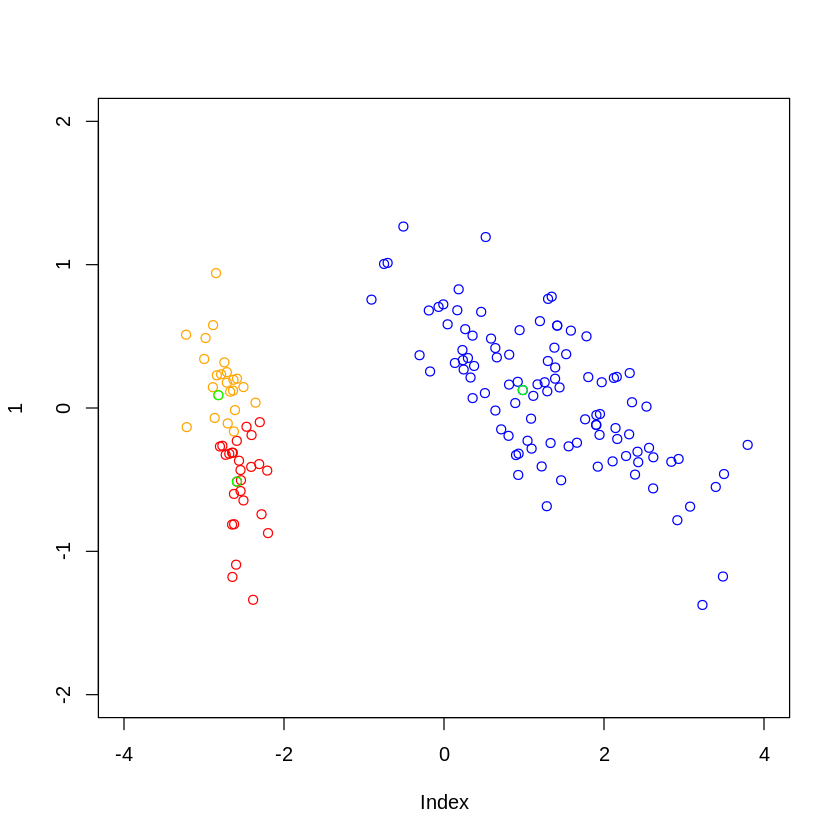

In [35]:
data <- cbind(data, labels)

first <- data[data[, "labels"] == 1,]
second <- data[data[, "labels"] == 2,]
third <- data[data[, "labels"] == 3,]

plot(1, col = "green", xlim = c(-4,4), ylim = c(-2,2), type = "n" )

points(first[,-3], col= "red")
points(second[,-3], col = "blue")
points(third[,-3], col = "orange")

points(data[centroids,], col = "green")

Again, quality of final result depends heavily on where the initial centroids landed.